# Plots of extreme indices

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import seaborn as sns
import scipy.stats # to calculate correlation
import math
from matplotlib.ticker import FormatStrFormatter # to change the axis labels so they have no decimal places

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR
import Extreme_indices_functions as funcX
# import obs_functions as funcO

In [3]:
# define path where obs data is store
path = '/g/data/w48/kb6999/Observations/obs_netcdfs_T/'

In [4]:
# open daily T data from 5 stations 
daily_T = xr.open_dataset(f'{path}Daily_T_Aus_5S.nc')
daily_T

<xarray.Dataset>
Dimensions:  (station: 5, time: 15705)
Coordinates:
  * time     (time) datetime64[ns] 1878-01-01 1878-01-02 ... 1920-12-31
  * station  (station) object 'Adelaide (030420)' ... 'Sydney (066062)'
Data variables:
    Tmin     (station, time) float64 ...
    Tmax     (station, time) float64 ...

In [5]:
# take the monthly mean temperature
mon_mean_T = daily_T.resample(time='M').mean(dim='time')

## calculate monthly anomalies 

In [9]:
# years to take as base period for percentiles
start_dates = [1872, 1880, 1867, 1870, 1870]
end_dates = [1887, 1910, 1888, 1900, 1900]

In [10]:
# calculate monthly anomalies for each station with regard to each different climatology
ds=[]
# with dask.diagnostics.ProgressBar:
for s, station in enumerate(mon_mean_T.station):
    anom = func.monthly_anomaly(mon_mean_T.sel(station=station), f'{start_dates[s]}', f'{end_dates[s]}')
    ds.append(anom)

In [11]:
mon_anom_T = xr.concat(ds, dim='station', coords='minimal')
mon_anom_T

<xarray.Dataset>
Dimensions:  (station: 5, time: 516)
Coordinates:
  * time     (time) datetime64[ns] 1878-01-31 1878-02-28 ... 1920-12-31
  * station  (station) <U21 'Adelaide (030420)' ... 'Sydney (066062)'
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Tmin     (station, time) float64 0.8406 0.8615 1.678 ... 0.3786 0.2384
    Tmax     (station, time) float64 3.192 -0.732 -0.5958 ... 0.1822 2.0 0.1429

In [13]:
# Krakatoa years
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [14]:
# select out 10 years around Krakatoa
K_daily_T = daily_T.sel(time=slice(e_pre5yrs[0], e_post5yrs[0]))
K_mon_mean_T = mon_mean_T.sel(time=slice(e_pre5yrs[0], e_post5yrs[0]))
K_mon_anom_T = mon_anom_T.sel(time=slice(e_pre5yrs[0], e_post5yrs[0]))

In [15]:
# take the multi_station mean
K_msm_T = K_mon_mean_T.mean(dim='station')

In [16]:
# open netcdf of extreme indices
ex_index_m = xr.open_dataset(f'{path}Obs_extreme_indices_m.nc')
ex_index_m

<xarray.Dataset>
Dimensions:  (station: 5, time: 516)
Coordinates:
  * time     (time) datetime64[ns] 1878-01-31 1878-02-28 ... 1920-12-31
  * station  (station) object 'Adelaide (030420)' ... 'Sydney (066062)'
Data variables: (12/14)
    FD       (station, time) int64 ...
    SU       (station, time) int64 ...
    ID       (station, time) int64 ...
    TR       (station, time) int64 ...
    TXx      (station, time) float64 ...
    TNx      (station, time) float64 ...
    ...       ...
    TN10p    (station, time) float64 ...
    TX10p    (station, time) float64 ...
    TN90p    (station, time) float64 ...
    TX90p    (station, time) float64 ...
    DTR      (station, time) float64 ...
    ETR      (station, time) float64 ...

In [17]:
# take the 10 years around Krakatoa
K_ex_index_m = ex_index_m.sel(time=slice(e_pre5yrs[0], e_post5yrs[0]))
K_ex_index_m

<xarray.Dataset>
Dimensions:  (station: 5, time: 121)
Coordinates:
  * time     (time) datetime64[ns] 1878-08-31 1878-09-30 ... 1888-08-31
  * station  (station) object 'Adelaide (030420)' ... 'Sydney (066062)'
Data variables: (12/14)
    FD       (station, time) int64 0 0 0 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0 0 0
    SU       (station, time) int64 1 2 10 12 19 24 22 16 ... 10 11 10 5 0 0 0 0
    ID       (station, time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TR       (station, time) int64 0 0 1 4 2 8 7 7 1 0 0 ... 1 2 5 5 0 0 0 0 0 0
    TXx      (station, time) float64 26.2 26.6 30.9 40.1 ... 22.3 22.4 19.9 23.8
    TNx      (station, time) float64 14.5 14.7 20.6 23.0 ... 15.6 14.0 14.8 13.1
    ...       ...
    TN10p    (station, time) float64 9.677 3.333 6.452 ... 3.333 3.226 19.35
    TX10p    (station, time) float64 6.452 0.0 6.452 10.0 ... 6.667 6.452 29.03
    TN90p    (station, time) float64 19.35 3.333 12.9 13.33 ... 20.0 6.452 6.452
    TX90p    (station, time) float64 16.13 10.0 9.677 20.0 ... 30.0 16.13 16.13
    DTR      (station, time) float64 8.958 10.56 12.14 ... 7.237 7.677 8.803
    ETR      (station, time) float64 23.0 23.8 26.2 32.5 ... 16.4 16.9 15.8 20.0

In [18]:
# take the multi_station mean
K_msm_index_m = K_ex_index_m.mean(dim='station')

## Figures

In [19]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [20]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

In [21]:
fplot=reload(fplot)

## extreme indices

In [22]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [23]:
blues = sns.color_palette("Blues_r")
greens = sns.color_palette("Greens_r")
reds = sns.color_palette("Reds_r")
oranges = sns.color_palette("Oranges_r")

In [24]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

## Good plots

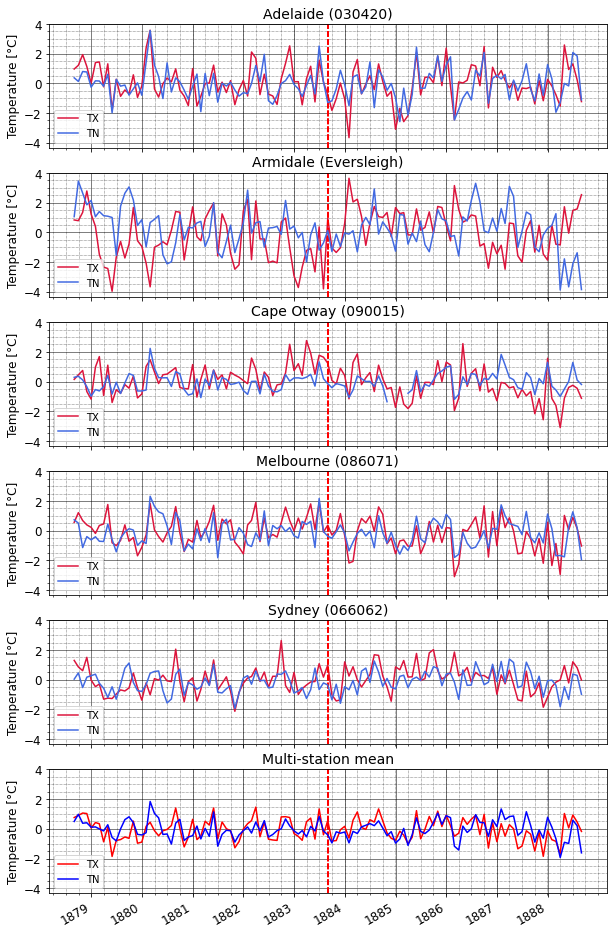

In [27]:
# Monthly Tmax and Tmin anomlaies 
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,16)) # make a figure

ds = K_mon_anom_T.Tmax
ds2 = K_mon_anom_T.Tmin

with dask.diagnostics.ProgressBar():
    for i, s in enumerate(ds.station):
        #plot number of frost days
        fplot.timeseries_noP(ds.sel(station=s), ax = axes[i], color='crimson', label = 'TX')
        # plot number of summer days
        ds2.sel(station=s).plot(ax = axes[i], color='royalblue', label = 'TN')
        axes[i].set(ylabel= f'Temperature [{deg}C]', title = s.data) 
        axes[i].set_xlabel(None)
        # add legend        
        axes[i].legend(loc='lower left')
    
    # add the multi-station mean
    fplot.timeseries_noP(ds.mean(dim='station'), ax = axes[i+1], color='red', label = 'TX')
    ds2.mean(dim='station').plot(ax = axes[i+1], color='blue', label = 'TN')
    axes[i+1].set(ylabel= f'Temperature [{deg}C]', title = 'Multi-station mean') 
    axes[i+1].set_xlabel(None)
    # add legend        
    axes[i+1].legend(loc='lower left')
        
# # make one legend for all tables (just use last axis to get info)  
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, 0.1)) # first arg to bbox is x second is y (x,y)

# set the axis ticks to be yearly 
axes[0].set_xticks(years)
axes[0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_mon_anom_TX+TN+msm_stacked.png', dpi=300, bbox_inches='tight')

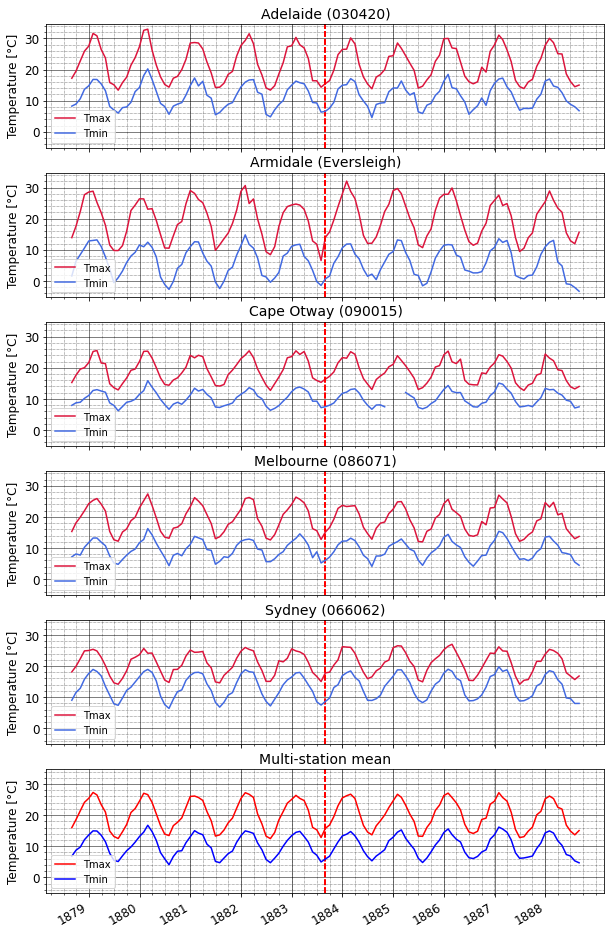

In [28]:
# Monthly Tmax and Tmin
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,16)) # make a figure

with dask.diagnostics.ProgressBar():
    for i, s in enumerate(K_mon_mean_T.station):
        #plot number of frost days
        fplot.timeseries_noP(K_mon_mean_T.Tmax.sel(station=s), ax = axes[i], color='crimson', label = 'Tmax')
        # plot number of summer days
        K_mon_mean_T.Tmin.sel(station=s).plot(ax = axes[i], color='royalblue', label = 'Tmin')
        axes[i].set(ylabel= f'Temperature [{deg}C]', title = s.data) 
        axes[i].set_xlabel(None)
        # add legend        
        axes[i].legend(loc='lower left')
    
    # add the multi-station mean
    fplot.timeseries_noP(K_msm_T.Tmax, ax = axes[i+1], color='red', label = 'Tmax')
    K_msm_T.Tmin.plot(ax = axes[i+1], color='blue', label = 'Tmin')
    axes[i+1].set(ylabel= f'Temperature [{deg}C]', title = 'Multi-station mean') 
    axes[i+1].set_xlabel(None)
    # add legend        
    axes[i+1].legend(loc='lower left')
        
# # make one legend for all tables (just use last axis to get info)  
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, 0.1)) # first arg to bbox is x second is y (x,y)

# set the axis ticks to be yearly 
axes[0].set_xticks(years)
axes[0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_Tmax+Tmin+msm_stacked.png', dpi=300, bbox_inches='tight')

<ipython-input-29-e678a8892539>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)
<ipython-input-29-e678a8892539>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)
<ipython-input-29-e678a8892539>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)
<ipython-input-29-e678a8892539>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)
<ipython-input-29-e678a8892539>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)


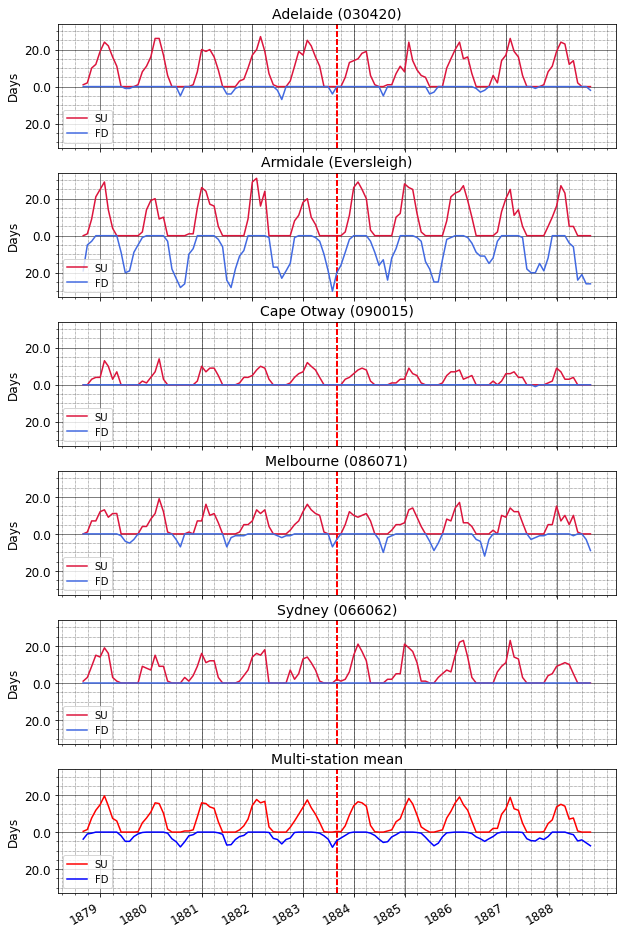

In [29]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,16)) # make a figure

ds = K_ex_index_m.SU
ds2 = -K_ex_index_m.FD

with dask.diagnostics.ProgressBar():
    for i, s in enumerate(ds.station):
        #plot number of summer days 
        fplot.timeseries_noP(ds.sel(station=s), ax = axes[i], color='crimson', label='SU')
        # plot number of frost days- make FD values negative so they appear inverted on yaxis
        ds2.sel(station=s).plot(ax = axes[i], color='royalblue', label='FD')
        axes[i].set(ylabel= 'Days', title = s.data) 
        axes[i].set_xlabel(None)

        # add legend        
        axes[i].legend(loc='lower left')

        # change the labels so that FD values are no longer listed as negative (basically inverse operation)
        labels = axes[i].get_yticks().tolist()
        for l in range(0, len(labels)):
            if labels[l]<0:
                labels[l] = -labels[l]
        # set the new labels
        axes[i].set_yticklabels(labels)
        
    # add the multi-station mean
    fplot.timeseries_noP(ds.mean(dim='station'), ax = axes[i+1], color='r', label = 'SU')
    ds2.mean(dim='station').plot(ax = axes[i+1], color='b', label = 'FD')
    axes[i+1].set(ylabel= f'Days', title = 'Multi-station mean') 
    axes[i+1].set_xlabel(None)
    # add legend        
    axes[i+1].legend(loc='lower left')
    

# set the axis ticks to be yearly 
axes[0].set_xticks(years)
axes[0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_FD+SU+msm_stacked.png', dpi=300, bbox_inches='tight')

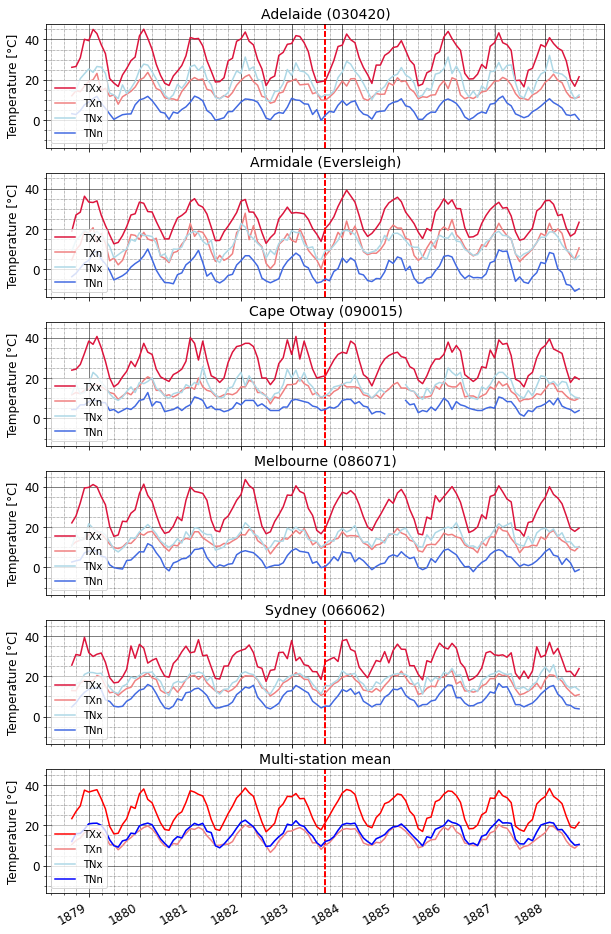

In [30]:
# TXx, TNn (daily max and mins) stacked
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,16)) # make a figure

ds = K_ex_index_m.TXx
ds2 = K_ex_index_m.TXn
ds3 = K_ex_index_m.TNx
ds4 = K_ex_index_m.TNn

with dask.diagnostics.ProgressBar():
    for i, s in enumerate(ds.station):
        #plot number of frost days
        fplot.timeseries_noP(ds.sel(station=s), ax = axes[i], color='crimson', label = 'TXx')
        # plot number of summer days
        ds2.sel(station=s).plot(ax = axes[i], color='lightcoral', label = 'TXn')
        ds3.sel(station=s).plot(ax = axes[i], color='lightblue', label = 'TNx')
        ds4.sel(station=s).plot(ax = axes[i], color='royalblue', label = 'TNn')
        axes[i].set(ylabel= f'Temperature [{deg}C]', title = s.data) 
        axes[i].set_xlabel(None)
        # add legend        
        axes[i].legend(loc='lower left')
        
    # add the multi-station mean
    fplot.timeseries_noP(ds.mean(dim='station'), ax = axes[i+1], color='r', label = 'TXx')
    ds2.mean(dim='station').plot(ax = axes[i+1], color='lightcoral', label = 'TXn')
    ds3.mean(dim='station').plot(ax = axes[i+1], color='lightblue', label = 'TNx')
    ds3.mean(dim='station').plot(ax = axes[i+1], color='b', label = 'TNn')
    axes[i+1].set(ylabel= f'Temperature [{deg}C]', title = 'Multi-station mean') 
    axes[i+1].set_xlabel(None)
    # add legend        
    axes[i+1].legend(loc='lower left')

# set the axis ticks to be yearly 
axes[0].set_xticks(years)
axes[0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_TXx+TXn+TNx+TNn+msm_stacked.png', dpi=300, bbox_inches='tight')

<ipython-input-31-b55ef805a494>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)
<ipython-input-31-b55ef805a494>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)
<ipython-input-31-b55ef805a494>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)
<ipython-input-31-b55ef805a494>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)
<ipython-input-31-b55ef805a494>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels)


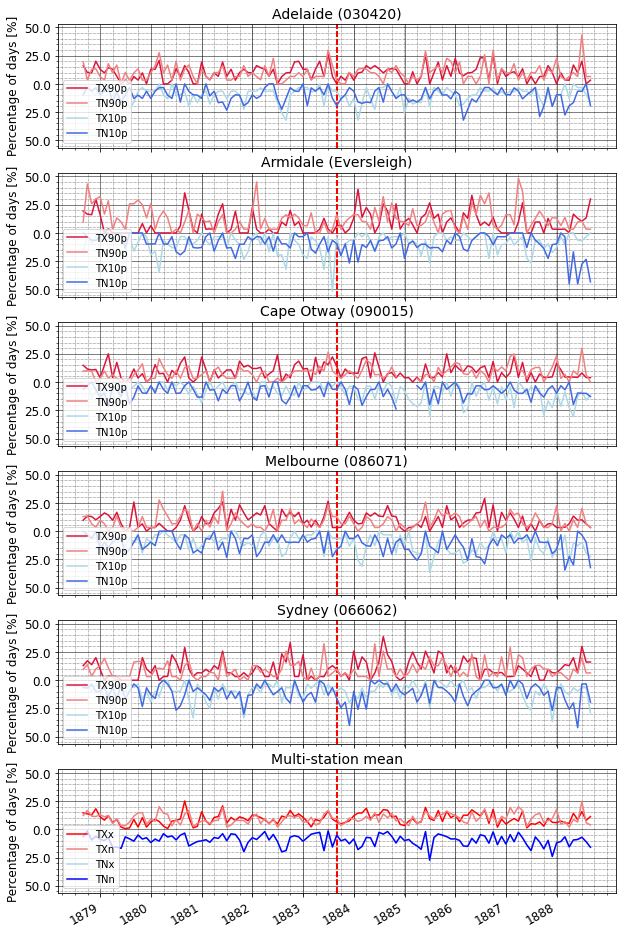

In [31]:
# Daily temperature anomalies stacked
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,16)) # make a figure

ds = K_ex_index_m.TX90p
ds2 = K_ex_index_m.TN90p
ds3 = -K_ex_index_m.TX10p
ds4 = -K_ex_index_m.TN10p
    
with dask.diagnostics.ProgressBar():
    for i, s in enumerate(ds.station):
        #plot ds1
        fplot.timeseries_noP(ds.sel(station=s), ax = axes[i], color='crimson', label = 'TX90p')
        # plot all other ds
        ds2.sel(station=s).plot(ax = axes[i], color='lightcoral', label = 'TN90p')
        ds3.sel(station=s).plot(ax = axes[i], color='lightblue', label = 'TX10p')
        ds4.sel(station=s).plot(ax = axes[i], color='royalblue', label = 'TN10p')
        axes[i].set(ylabel= f'Percentage of days [%]', title = s.data) 
        axes[i].set_xlabel(None)
        
        # add legend        
        axes[i].legend(loc='lower left')
        
        # change the labels so that values are no longer listed as negative (basically inverse operation)
        labels = axes[i].get_yticks().tolist()
        for l in range(0, len(labels)):
            if labels[l]<0:
                labels[l] = -labels[l]
        # set the new labels
        axes[i].set_yticklabels(labels)
        
    # add the multi-station mean
    fplot.timeseries_noP(ds.mean(dim='station'), ax = axes[i+1], color='r', label = 'TXx')
    ds2.mean(dim='station').plot(ax = axes[i+1], color='lightcoral', label = 'TXn')
    ds3.mean(dim='station').plot(ax = axes[i+1], color='lightblue', label = 'TNx')
    ds3.mean(dim='station').plot(ax = axes[i+1], color='b', label = 'TNn')
    axes[i+1].set(ylabel= f'Percentage of days [%]', title = 'Multi-station mean') 
    axes[i+1].set_xlabel(None)
    # add legend        
    axes[i+1].legend(loc='lower left')
    

# set the axis ticks to be yearly 
axes[0].set_xticks(years)
axes[0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_T90p+T10p+msm_stacked.png', dpi=300, bbox_inches='tight')

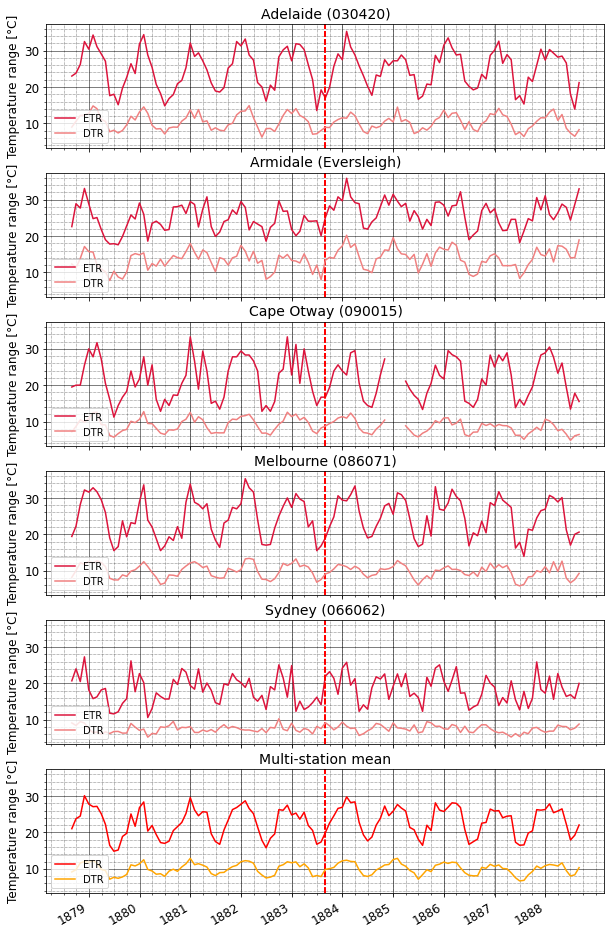

In [32]:
# Daily temperature anomalies stacked
ds = K_ex_index_m.ETR
ds2 = K_ex_index_m.DTR

fig, axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,16)) # make a figure

with dask.diagnostics.ProgressBar():        
    for i, s in enumerate(ds.station):
        #plot ds1
        fplot.timeseries_noP(ds.sel(station=s), ax = axes[i], color='crimson', label = 'ETR')
        # plot all other ds
        ds2.sel(station=s).plot(ax = axes[i], color='lightcoral', label = 'DTR')
        axes[i].set(ylabel= f'Temperature range [{deg}C]', title = s.data) 
        axes[i].set_xlabel(None)
        
        # add legend        
        axes[i].legend(loc='lower left')
        
    # add the multi-station mean
    fplot.timeseries_noP(ds.mean(dim='station'), ax = axes[i+1], color='r', label = 'ETR')
    ds2.mean(dim='station').plot(ax = axes[i+1], color='orange', label = 'DTR')
    axes[i+1].set(ylabel= f'Temperature range [{deg}C]', title = 'Multi-station mean') 
    axes[i+1].set_xlabel(None)
    # add legend        
    axes[i+1].legend(loc='lower left')
        
# # make one legend for all tables (just use last axis to get info)  
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, 0.1)) # first arg to bbox is x second is y (x,y)

# set the axis ticks to be yearly 
axes[0].set_xticks(years)
axes[0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_DTR+ETR+msm_stacked.png', dpi=300, bbox_inches='tight')

## Extreme indices by month

In [34]:
years2 = pd.date_range(e_pre5yrs[0]+2*pd.offsets.YearBegin(), e_post5yrs[0], freq='2YS')

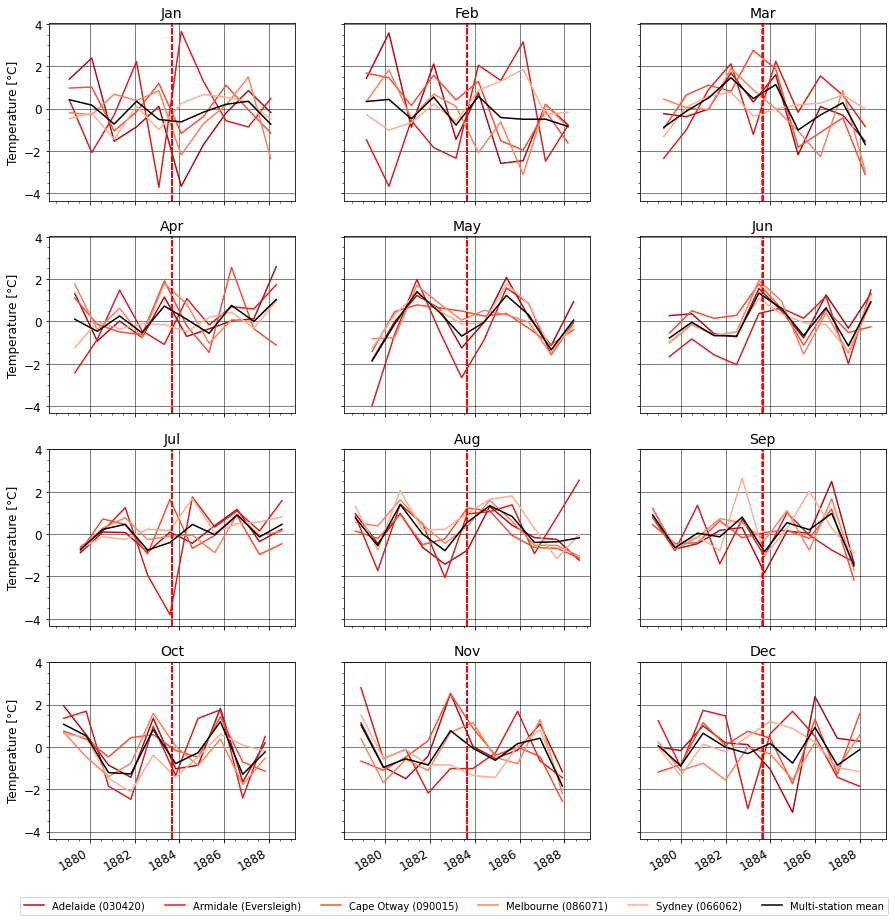

In [38]:
# plot by month
# define the number of datasets to 
ds = K_mon_anom_T.Tmax

row = 4 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 3
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(15,15)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(time=(ds['time.month']==m))
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        axes[r, m-rmin].set(ylabel=None, title = months[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # add line to mark eruption date
        date = np.array(f'1883-08-27T00:00:00.000000000', dtype='datetime64[ns]')
        axes[r, m-rmin].axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col
    
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=6) 

    
# set the axis ticks to be every second year
axes[0,0].set_xticks(years2)
axes[0,0].set_xticklabels(years2.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_mon_anom_TX+msm_by_month.png', dpi=300, bbox_inches='tight')

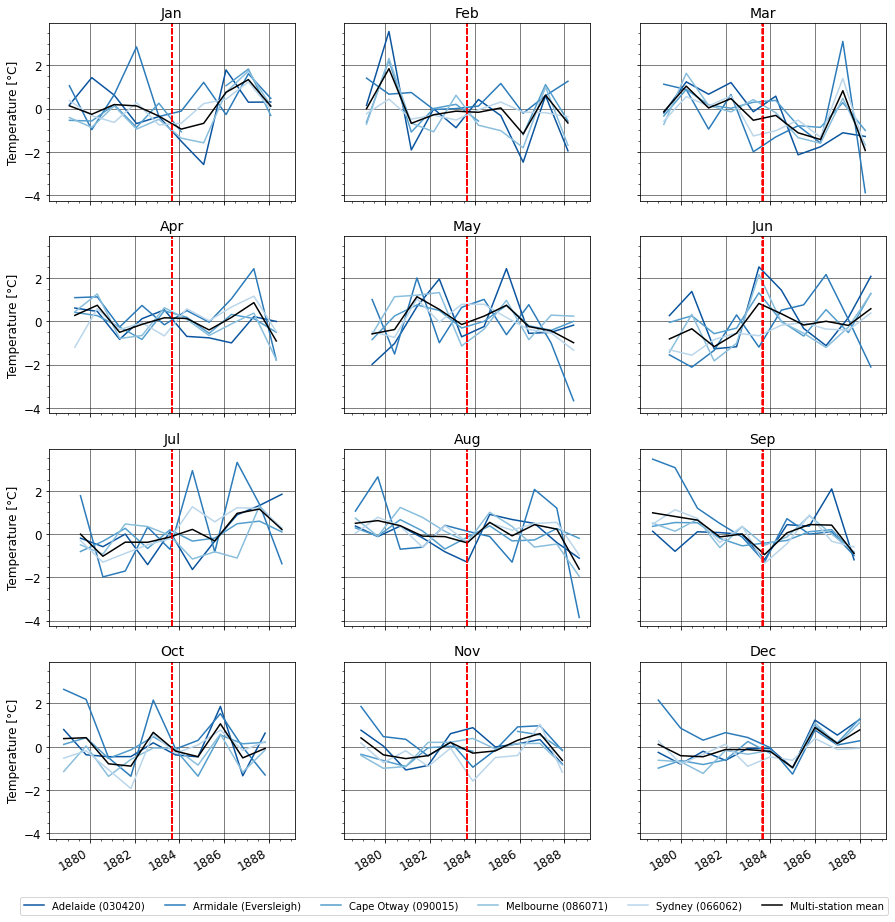

In [40]:
# plot by month
# define the number of datasets to 
ds = K_mon_anom_T.Tmin

row = 4 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 3
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(15,15)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(time=(ds['time.month']==m))
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=blues[i], label = s.data)
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')

        axes[r, m-rmin].set(ylabel=None, title = months[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # add line to mark eruption date
        date = np.array(f'1883-08-27T00:00:00.000000000', dtype='datetime64[ns]')
        axes[r, m-rmin].axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col
    
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=6) 

    
# set the axis ticks to be every second year
axes[0,0].set_xticks(years2)
axes[0,0].set_xticklabels(years2.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_mon_anom_TN+msm_by_month.png', dpi=300, bbox_inches='tight')

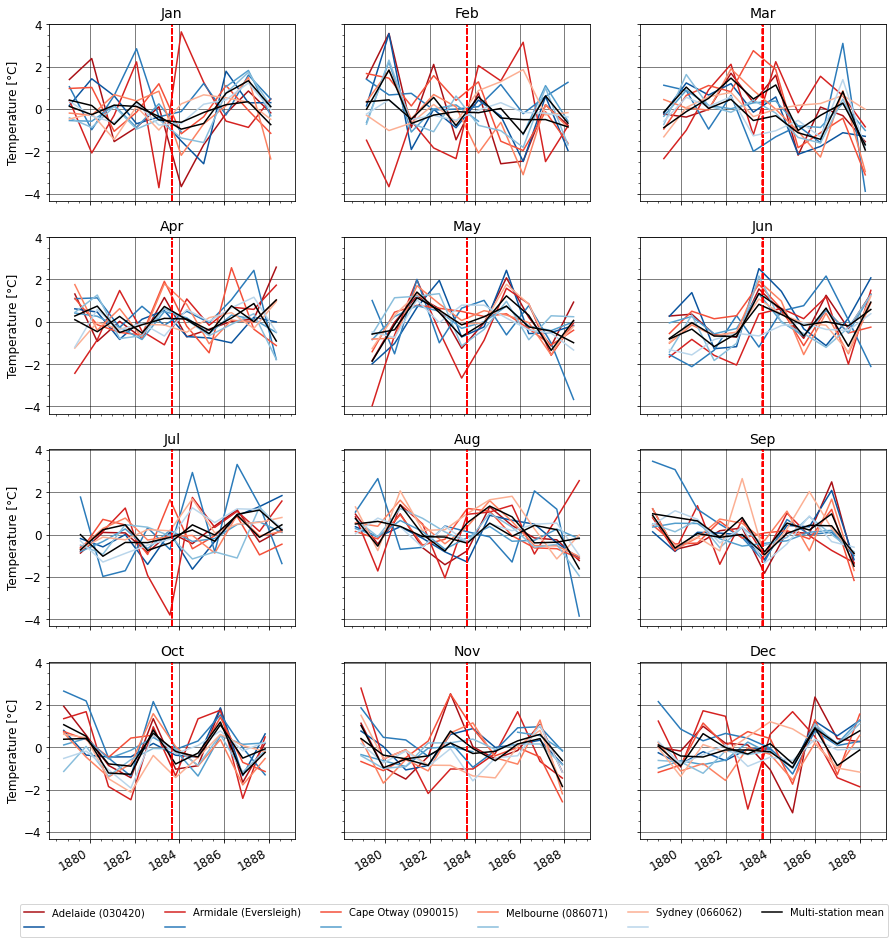

In [35]:
# plot by month
# define the number of datasets to 
ds = K_mon_anom_T.Tmax
ds2 = K_mon_anom_T.Tmin

row = 4 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 3
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(15,15)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(time=(ds['time.month']==m))
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k')

        axes[r, m-rmin].set(ylabel=None, title = months[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # add line to mark eruption date
        date = np.array(f'1883-08-27T00:00:00.000000000', dtype='datetime64[ns]')
        axes[r, m-rmin].axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col
    
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=6) 

    
# set the axis ticks to be every second year
axes[0,0].set_xticks(years2)
axes[0,0].set_xticklabels(years2.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_mon_anom_TX+TN+msm_by_month.png', dpi=300, bbox_inches='tight')

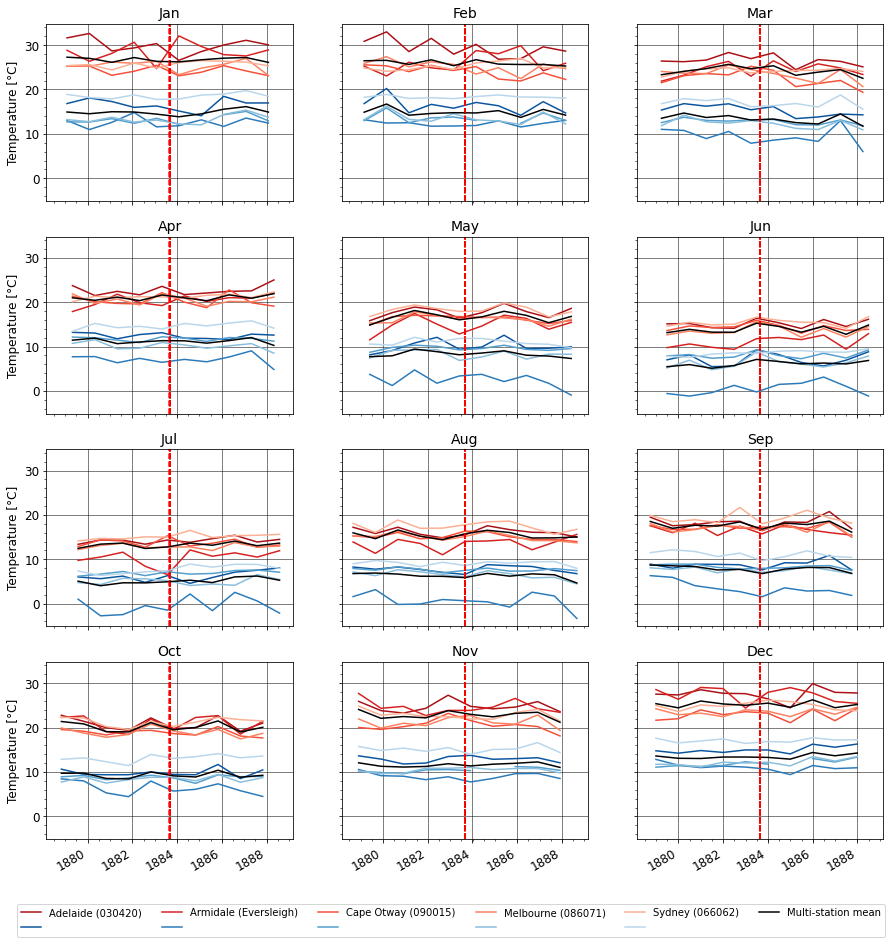

In [26]:
# plot by month
# define the number of datasets to 
ds = K_mon_mean_T.Tmax
ds2 = K_mon_mean_T.Tmin

row = 4 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 3
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(15,15)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(time=(ds['time.month']==m))
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k')

        axes[r, m-rmin].set(ylabel=None, title = months[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # add line to mark eruption date
        date = np.array(f'1883-08-27T00:00:00.000000000', dtype='datetime64[ns]')
        axes[r, m-rmin].axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col
    
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=6) 

    
# set the axis ticks to be every second year
axes[0,0].set_xticks(years2)
axes[0,0].set_xticklabels(years2.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_Tmax+Tmin+msm_by_month.png', dpi=300, bbox_inches='tight')

<ipython-input-31-07bd3739c00a>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-31-07bd3739c00a>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-31-07bd3739c00a>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-31-07bd3739c00a>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-31-07bd3739c00a>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-31-07bd3739c00a>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-31-07bd3739c00a>:43: UserWarning: FixedFormatter should only be use

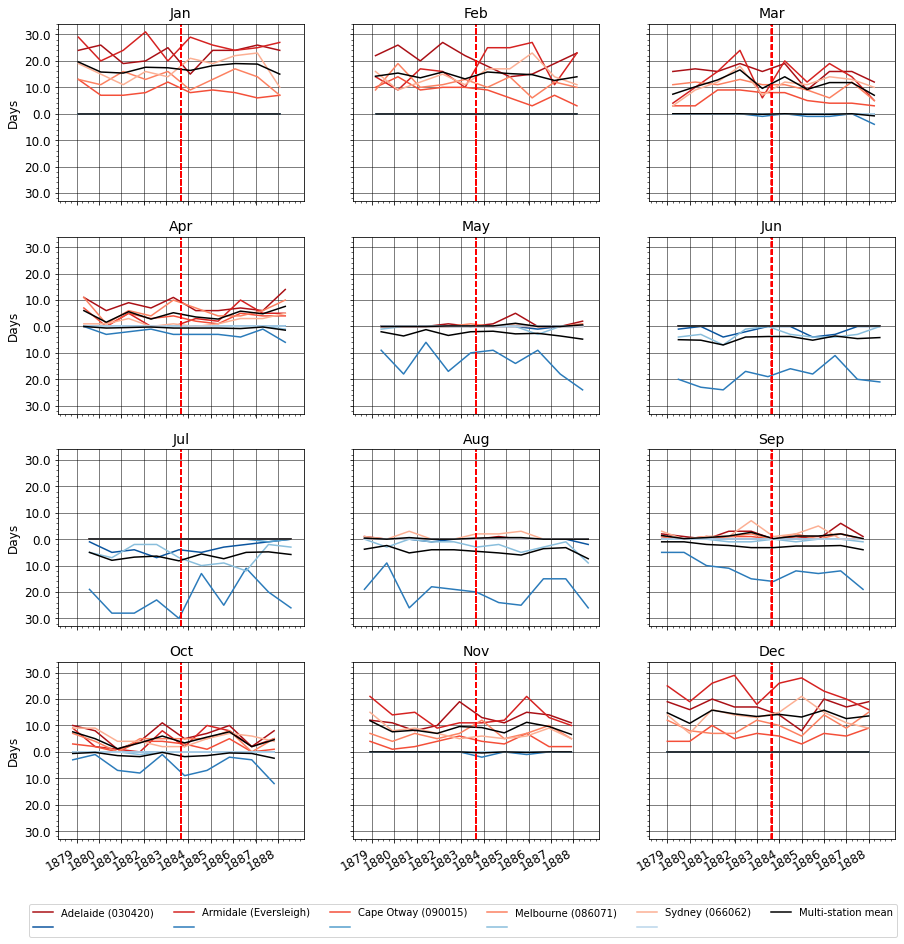

In [31]:
# plot by month
# define the number of datasets to 
ds = K_ex_index_m.SU
ds2 = -K_ex_index_m.FD

row = 4 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 3
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(15,15)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(time=(ds['time.month']==m))
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k')
        
        axes[r, m-rmin].set(ylabel=None, title = months[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # add line to mark eruption date
        date = np.array(f'1883-08-27T00:00:00.000000000', dtype='datetime64[ns]')
        axes[r, m-rmin].axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
        
        
        # change the labels so that FD values are no longer listed as negative (basically inverse operation)
        labels = axes[r, m-rmin].get_yticks().tolist()
        for l, vals in enumerate(labels):
            if labels[l]<0:
                labels[l] = -labels[l]
        # set the new labels
        axes[r, m-rmin].set_yticklabels(labels)      
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Days')

    rmin = rmax
    rmax = rmin+col
    
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=6) 

    
# set the axis ticks to be yearly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_FD+SU+msm_by_month.png', dpi=300, bbox_inches='tight')

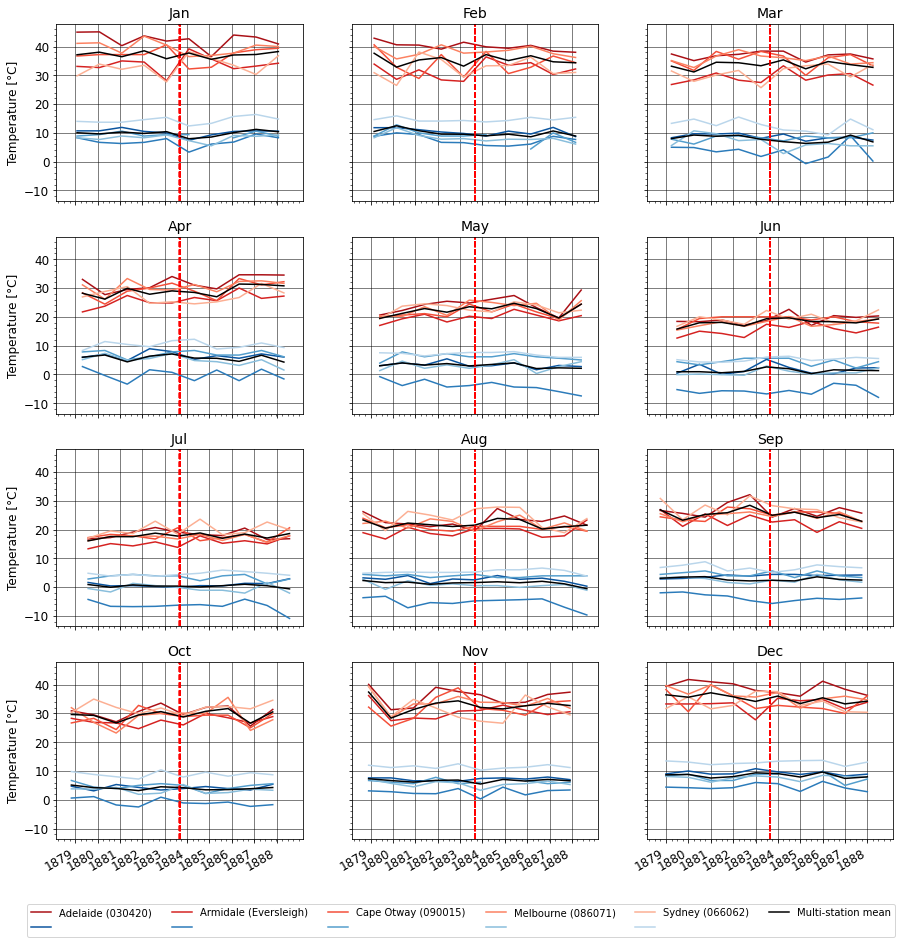

In [32]:
# plot by month
# define the number of datasets to 
ds = K_ex_index_m.TXx
ds2 = K_ex_index_m.TNn

row = 4 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 3
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(15,15)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(time=(ds['time.month']==m))
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k')
        
        axes[r, m-rmin].set(ylabel=None, title = months[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # add line to mark eruption date
        date = np.array(f'1883-08-27T00:00:00.000000000', dtype='datetime64[ns]')
        axes[r, m-rmin].axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
               
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col
    
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=6) 

# set the axis ticks to be yearly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_TXx+TNn+msm_by_month.png', dpi=300, bbox_inches='tight')       

<ipython-input-33-b18c41414928>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-33-b18c41414928>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-33-b18c41414928>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-33-b18c41414928>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-33-b18c41414928>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-33-b18c41414928>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-33-b18c41414928>:42: UserWarning: FixedFormatter should only be use

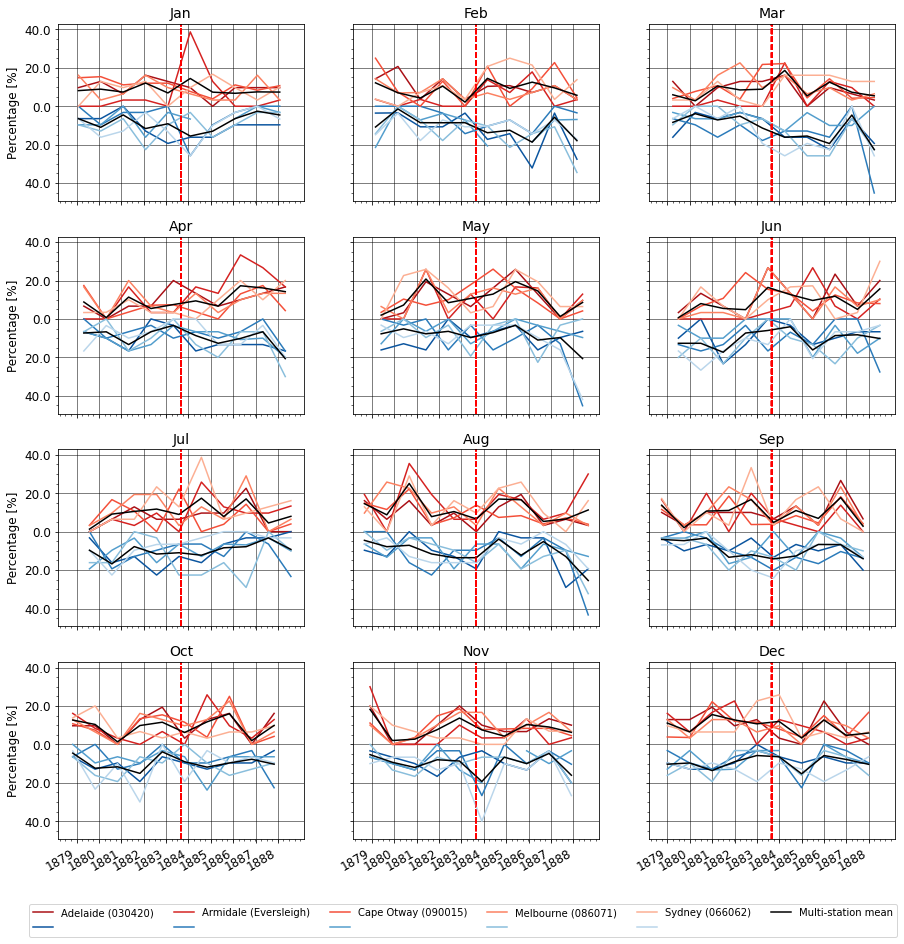

In [33]:
# plot by month
# define the number of datasets to 
ds = K_ex_index_m.TX90p
ds2 = (-K_ex_index_m.TN10p)

row = 4 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 3
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(15,15)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(time=(ds['time.month']==m))
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k')
        
        axes[r, m-rmin].set(ylabel=None, title = months[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # add line to mark eruption date
        date = np.array(f'1883-08-27T00:00:00.000000000', dtype='datetime64[ns]')
        axes[r, m-rmin].axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
        
        # change the labels so that FD values are no longer listed as negative (basically inverse operation)
        labels = axes[r, m-rmin].get_yticks().tolist()
        for l, vals in enumerate(labels):
            if labels[l]<0:
                labels[l] = -labels[l]
        # set the new labels
        axes[r, m-rmin].set_yticklabels(labels)
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Percentage [%]')
#     # show 0 decimal places in yaxis labels, can't use this cos it ovverrides the removal of negative sign
#     axes[r, 0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    rmin = rmax
    rmax = rmin+col

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=6) 
    
# set the axis ticks to be yearly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_TX90p+TN10p+msm_by_month.png', dpi=300, bbox_inches='tight')

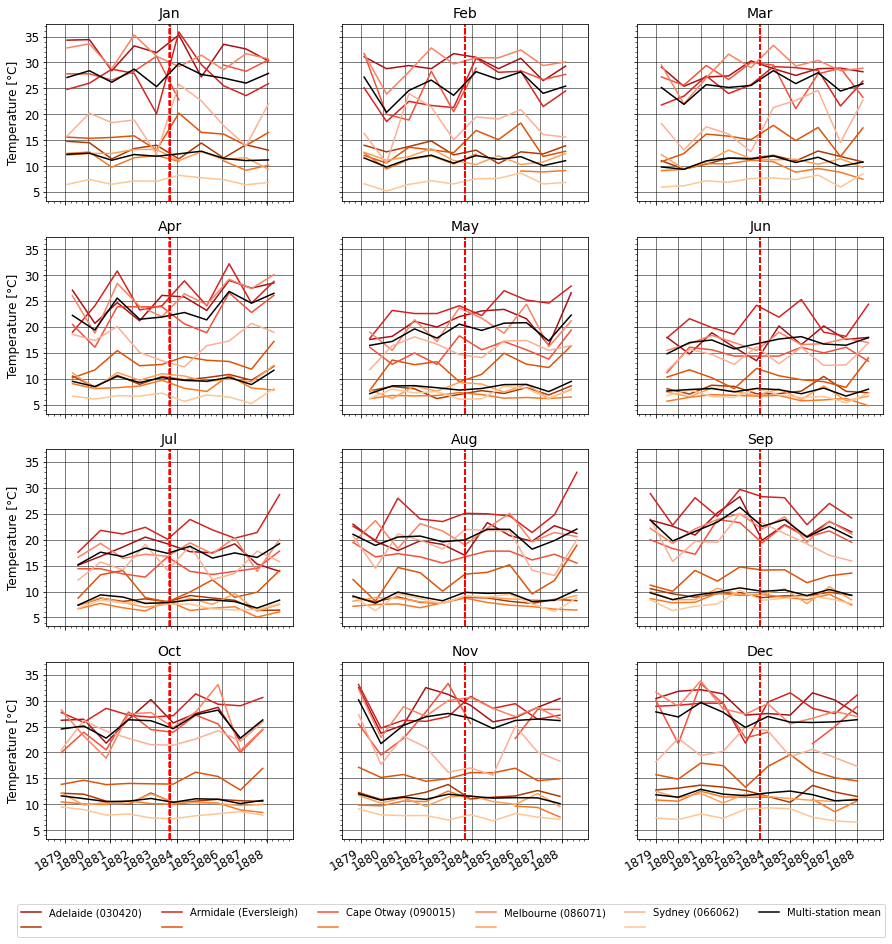

In [34]:
# plot by month
# define the number of datasets to 
ds = K_ex_index_m.ETR
ds2 = K_ex_index_m.DTR

row = 4 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 3
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(15,15)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(time=(ds['time.month']==m))
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color=oranges[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(time=(ds['time.month']==m)).plot(ax = axes[r, m-rmin], color='k')
        
        axes[r, m-rmin].set(ylabel=None, title = months[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # add line to mark eruption date
        date = np.array(f'1883-08-27T00:00:00.000000000', dtype='datetime64[ns]')
        axes[r, m-rmin].axvline(x=date, color = 'r', linestyle = '--', alpha = 0.9, linewidth='1.5')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col
    
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=6) 

    
# set the axis ticks to be yearly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('O_timeseries_monthly_ETR+DTR+msm_by_month.png', dpi=300, bbox_inches='tight')

## extreme indices by season